## Semester 1 Project Submission

Please fill out:
* Student name: 
* Instructor name: 


In [4]:
# Your code here - remember to use markdown cells for comments as well!

In [4]:
import pandas as pd
import sqlite3
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline
# You'll need to unzip the db locally.
conn = sqlite3.connect('zippedData/im.db')

# Habib Khadri

# Nick Kirbabas

# Seerat Mutneja

# Sidhya Raman

# Douglas Riggs

In [5]:
# Reading table names
pd.read_sql('''
SELECT 
    name
FROM 
    sqlite_schema
WHERE 
    type ='table' AND 
    name NOT LIKE 'sqlite_%';
''',conn)
#Adding a comment to initialize my branch

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'averagerating', 'numvotes'],
      dtype='object')


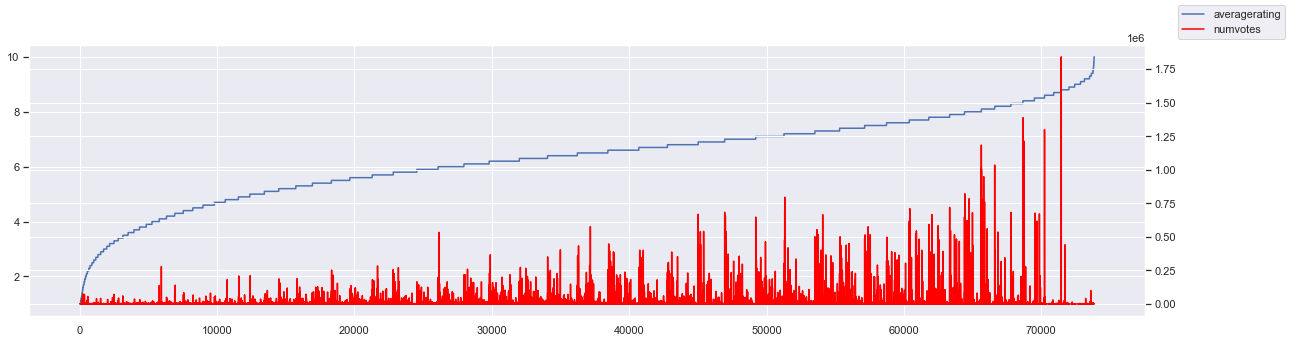

In [62]:
# Get all movies with ratings
movie_df = pd.read_sql('''
SELECT *
FROM movie_basics
INNER JOIN movie_ratings
    USING (movie_id)
ORDER BY averagerating
''',conn)

# Create a plot of averagerating vs numvotes, just for fun
sns.set_theme(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20,5))
fig, ax = plt.subplots(figsize=(20,5))
ax2 = ax.twinx()
movie_df.averagerating.plot(ax=ax, stacked=True);
movie_df.numvotes.plot(ax=ax2, stacked=True, color='red');
ax.figure.legend();

<AxesSubplot:xlabel='averagerating', ylabel='Count'>

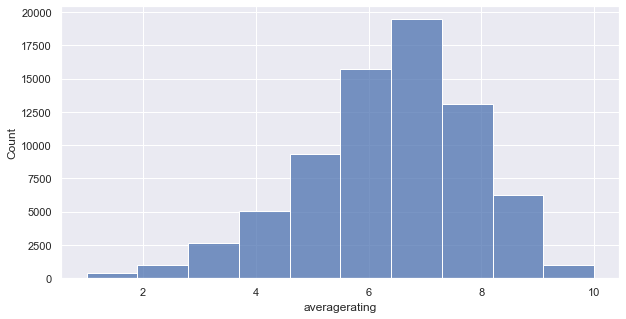

In [64]:
#Creating a distribution of ratings

fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(movie_df.averagerating, ax=ax, bins=10)

Looks pretty normal, right?

In [217]:
# check skew/kurtosis, not doing it right now, it's normal, lets be real.

In [215]:
# create dataframe grouped by genre
movie_genre_df = pd.read_sql('''
SELECT genres,
    SUM(averagerating * numvotes) AS rating_raw_points,
    SUM(numvotes) AS genre_num_votes
FROM movie_basics
INNER JOIN movie_ratings
    USING (movie_id)
GROUP BY genres
ORDER BY genre_num_votes DESC
''',conn)
movie_genre_df.head()

,genres,rating_raw_points,genre_num_votes
0,"Action,Adventure,Sci-Fi",167484518.9,23023248
1,"Action,Adventure,Fantasy",64441503.9,9658883
2,"Adventure,Animation,Comedy",62169758.0,8687435
3,Drama,59994733.2,8395521
4,"Comedy,Drama,Romance",52276271.6,7665463


In [146]:
# Splitting the grouped genres into individual rows
separated_movie_genre_df = movie_genre_df.reset_index()
separated_movie_genre_df = pd.DataFrame(movie_genre_df.genres.str.split(','), \
                                        index=separated_movie_genre_df['index'], ).explode('genres')
separated_movie_genre_df.head()




,genres
index,
0,Action
0,Adventure
0,Sci-Fi
1,Action
1,Adventure


In [149]:
# Create a column for how many genres each movie has - after we join,
# We'll use this to separate a movie's votes by each genre.
separated_movie_genre_df['genre_count'] = separated_movie_genre_df.groupby('index').count()
separated_movie_genre_df.head(11)

,genres,genre_count
index,,
0,Action,3
0,Adventure,3
0,Sci-Fi,3
1,Action,3
1,Adventure,3
1,Fantasy,3
2,Adventure,3
2,Animation,3
2,Comedy,3


In [188]:
# Join with original, and divide by genres the movie had.
refined_movie_genre_df = separated_movie_genre_df\
.join(movie_genre_df, how='inner', lsuffix='_separated', rsuffix='_original')
refined_movie_genre_df['rating_raw_points_per_genre'] = \
(refined_movie_genre_df['rating_raw_points'] / refined_movie_genre_df['genre_count']).round()
refined_movie_genre_df['num_votes_per_genre'] = \
(refined_movie_genre_df['genre_num_votes'] / refined_movie_genre_df['genre_count']).round()
refined_movie_genre_df['movies_in_genre'] = 1

refined_movie_genre_df.head()


,genres_separated,genre_count,genres_original,rating_raw_points,genre_num_votes,rating_raw_points_per_genre,num_votes_per_genre,movies_in_genre
0,Action,3,"Action,Adventure,Sci-Fi",167484518.9,23023248,55828173.0,7674416.0,1
0,Adventure,3,"Action,Adventure,Sci-Fi",167484518.9,23023248,55828173.0,7674416.0,1
0,Sci-Fi,3,"Action,Adventure,Sci-Fi",167484518.9,23023248,55828173.0,7674416.0,1
1,Action,3,"Action,Adventure,Fantasy",64441503.9,9658883,21480501.0,3219628.0,1
1,Adventure,3,"Action,Adventure,Fantasy",64441503.9,9658883,21480501.0,3219628.0,1


In [189]:
# Group by genre, clean out unnecessary columns
refined_movie_genre_df = refined_movie_genre_df\
                            .groupby('genres_separated')\
                            .sum()\
                            .drop('genre_count', axis=1)\
                            .drop('rating_raw_points', axis=1)\
                            .drop('genre_num_votes', axis=1)\
                            .reset_index()
refined_movie_genre_df.head()

,genres_separated,rating_raw_points_per_genre,num_votes_per_genre,movies_in_genre
0,Action,241801383.0,35147088.0,153
1,Adult,175.0,76.0,2
2,Adventure,200709819.0,28463543.0,140
3,Animation,37457496.0,5160061.0,113
4,Biography,57476289.0,7707304.0,95


In [190]:
grouped_movies_by_genre = refined_movie_genre_df.groupby('genres_separated').sum()
grouped_movies_by_genre.head()

,rating_raw_points_per_genre,num_votes_per_genre,movies_in_genre
genres_separated,,,
Action,241801383.0,35147088.0,153
Adult,175.0,76.0,2
Adventure,200709819.0,28463543.0,140
Animation,37457496.0,5160061.0,113
Biography,57476289.0,7707304.0,95


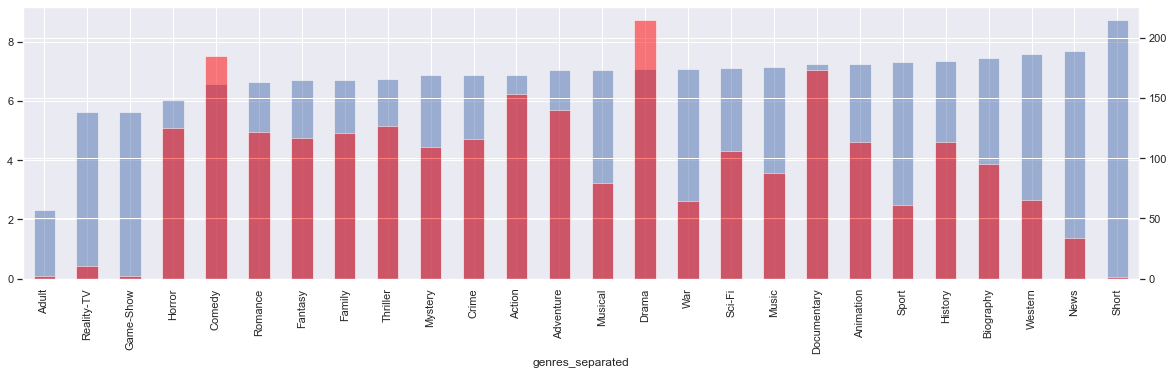

In [193]:
grouped_movies_by_genre['average_rating'] = \
grouped_movies_by_genre['rating_raw_points_per_genre'] \
/ grouped_movies_by_genre['num_votes_per_genre']

fig, ax = plt.subplots(figsize=(20,5))
ax2 = ax.twinx()
# movie_df.averagerating.plot(ax=ax, stacked=True);
# movie_df.numvotes.plot(ax=ax2, stacked=True, color='red');

grouped_movies_by_genre.sort_values('average_rating').average_rating\
.plot.bar(ax=ax, alpha = .5);
grouped_movies_by_genre.sort_values('average_rating').movies_in_genre\
.plot.bar(ax=ax2, color='red', alpha=.5);
# ax.figure.legend();


Some sample volumes are really low, might want to throw out genres with <30 movies.

In [196]:
bom_movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
bom_movie_gross_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [203]:
rt_movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
rt_movie_info_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [213]:
rt_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t',\
                            encoding = 'unicode_escape')
rt_reviews_df.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [210]:
tmdb_movies_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
tmdb_movies_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [211]:
tn_movie_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
tn_movie_budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


# Andrew Yang